# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

*Признаки*: 

DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
NotRepaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  

*Целевой признак*:   

Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
df.duplicated().sum()

4

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Мы обнаружили пропущенные значения в определенных столбцах. Ниже определимся, что с ними сделем. 
Также обнаружены 4 дубликата, которые мы удалим.

Выделим признаки, которые будут важны для обучения модели, и которые могут повлиять на цену.

VehicleType - тип машины определяет ее функционал. Чем больше возможносей у машины, тем выше цена.  
Gearbox - наличие автоматической коробки передач. Определенно влияет на цену.   
Power - мощность в лошадиных силах напрямую влияет на цену.  
Kilometer - чем меньше машина проехала, тем выше стоимость.  
FuelType - тип топлива тоже влиет на цену.  
Brand - компания, которая создала автомобиль показывает качество и надежность автомобиля.  
NotRepaired - машины, которые побывали в дорожно-транспортных проишествиях означает. Цена сразу снижается, если были дтп.   
RegistrationYear - год регистрации определяет сколько уже лет машина на ходу. Чем больше возраст, тем меньше цена.  
Model - усовершенстовванная модель определенной компании будет стоить дороже, чем модель постарее этой же компании.   

Остальные столбцы для модели не требуются, так как не влияют на стоимость.

Столбцы, требующие обработки:

VehicleType - восстановим пропущенные значения по популярному типу из столбца Brand.  
Gearbox - для всех NaN установим значение 'manual'.  
Power - можно исправить на реальные значения в машинах.  
FuelType - восстановим пропущенные значения по популярному типу из столбца Brand.  
NotRepaired - для всех NaN установим значение 'yes'.  
RegistrationYear - можно исправить на реальные значения в машинах.   
Model - для всех NaN установим значение 'unknown'.  

In [8]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Так как для машинного обучения нам не понадобятся все столбцы, то оставим только необходимые. 

In [9]:
filtr_df = df[['VehicleType', 
                         'Gearbox', 
                         'Power',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'NotRepaired',
                         'RegistrationYear',
                         'Model',
                         'Price']]

In [10]:
filtr_df['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13440        1
1414         1
8069         1
10370        1
384          1
Name: Price, Length: 3731, dtype: int64

Видим, что у 10772 значений нет цены. Попробуем их удалить и посмотреть распределение цен.

count    343593.000000
mean       4555.147363
std        4515.076200
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

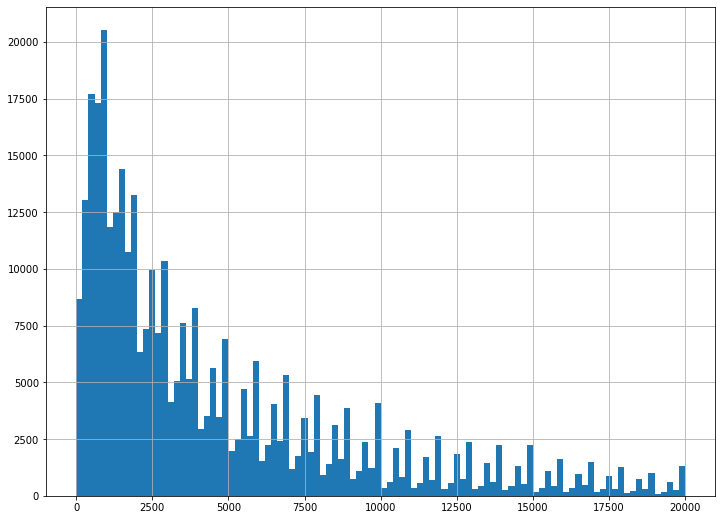

In [11]:
filtr_df = filtr_df.query('Price > 0')
filtr_df['Price'].hist(bins=100, figsize=(12,9))
filtr_df['Price'].describe()

Выделим квантили 10% и 80%

In [12]:
filtr_df['Price'].quantile([0.1, 0.8])

0.1     590.0
0.8    7800.0
Name: Price, dtype: float64

Цена у нас обозначена в евро. 590 евро это примерно 50 000 рублей - минимальная цена для продажи поддержанного авто. Квантиль в 80% как раз выбран из-за выбросов после 7500 евро.

In [13]:
filtr_df = filtr_df.query('590 <= Price <= 7800')
filtr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241007 entries, 3 to 354368
Data columns (total 10 columns):
VehicleType         217990 non-null object
Gearbox             229591 non-null object
Power               241007 non-null int64
Kilometer           241007 non-null int64
FuelType            221350 non-null object
Brand               241007 non-null object
NotRepaired         194818 non-null object
RegistrationYear    241007 non-null int64
Model               229225 non-null object
Price               241007 non-null int64
dtypes: int64(4), object(6)
memory usage: 20.2+ MB


In [14]:
filtr_df['RegistrationYear'].describe()

count    241007.000000
mean       2003.042787
std          61.059475
min        1000.000000
25%        1999.000000
50%        2002.000000
75%        2006.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Наблюдаются выбросы в годах регистрации. Минимальный 1000 год? Ага! Щаас. Отсечем ненужные года после того как узнаем максимальную дату скачивания анкеты автомобиля. 

In [15]:
date = pd.to_datetime(df['DateCrawled'])
date.max()

Timestamp('2016-04-07 14:36:58')

count    229707.000000
mean       2001.760982
std           6.027108
min        1910.000000
25%        1999.000000
50%        2002.000000
75%        2005.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

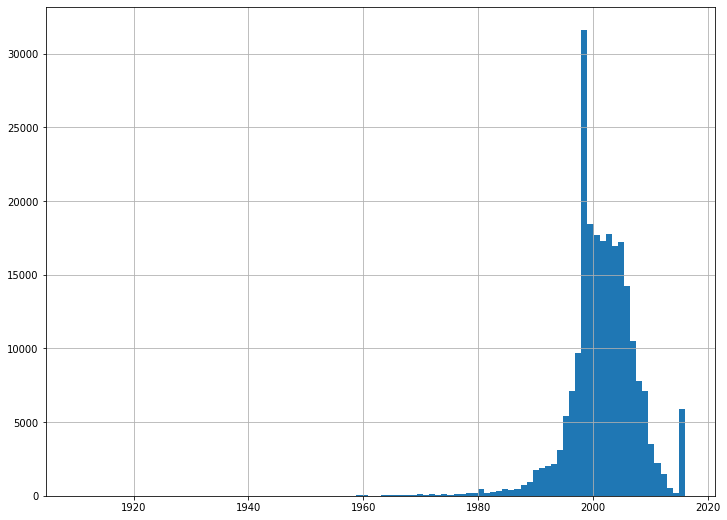

In [16]:
filtr_df = filtr_df.query('1899 < RegistrationYear < 2017')
filtr_df['RegistrationYear'].hist(bins=100, figsize=(12,9))
filtr_df['RegistrationYear'].describe()

Отсечем еще лишние года. 1960 год показывает, что там могут быть конечно старые, но работающие машины, которые выставляют на продажу. 

count    229594.000000
mean       2001.788139
std           5.892667
min        1960.000000
25%        1999.000000
50%        2002.000000
75%        2005.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

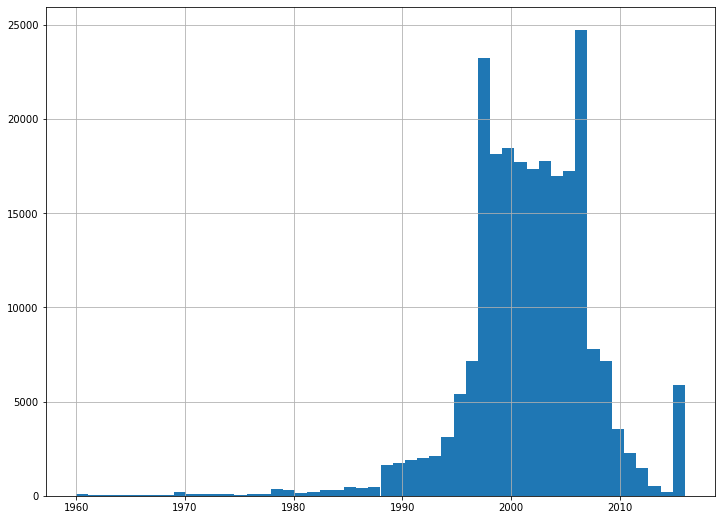

In [17]:
filtr_df = filtr_df.query('1959 < RegistrationYear < 2017')
filtr_df['RegistrationYear'].hist(bins=50, figsize=(12,9))
filtr_df['RegistrationYear'].describe()

Как и было задумано, меняем значения НаН в столбцах Gearbox, NotRepaired, Model

In [18]:
filtr_df.fillna({'Gearbox':'manual', 'NotRepaired':'yes', 'Model':'unknown'}, inplace=True)
filtr_df.isna().sum()

VehicleType         11724
Gearbox                 0
Power                   0
Kilometer               0
FuelType            15346
Brand                   0
NotRepaired             0
RegistrationYear        0
Model                   0
Price                   0
dtype: int64

Посмотрим на количество пропущенных значений в столбце VehicleType

In [19]:
display(filtr_df['VehicleType'].value_counts())
filtr_df['VehicleType'].isna().sum()

sedan          63769
small          59515
wagon          44540
bus            20569
convertible    12370
coupe           9671
suv             5169
other           2267
Name: VehicleType, dtype: int64

11724

Произведем замену НаН в соотвествии с популярным типом кузова для каждого бренда.

In [20]:
vehicle_type_pivot_table = filtr_df.pivot_table(index=['VehicleType'], 
                                                columns=['Brand'], 
                                                values=['Price'], 
                                                aggfunc=['count'])

display(vehicle_type_pivot_table)

count                                                     \
                 Price                                                      
Brand       alfa_romeo    audi      bmw chevrolet chrysler citroen  dacia   
VehicleType                                                                 
bus                NaN    10.0      4.0      93.0    332.0  1012.0   15.0   
convertible      111.0   666.0   1631.0       6.0    185.0    96.0    NaN   
coupe            173.0   639.0   2397.0      45.0     16.0   123.0    NaN   
other              7.0    78.0    165.0      18.0      6.0    84.0    5.0   
sedan            715.0  7329.0  10956.0     138.0    187.0   506.0   96.0   
small            169.0   907.0    290.0     562.0     10.0  1282.0  178.0   
suv                NaN    17.0    189.0     145.0     11.0     6.0   46.0   
wagon            363.0  6218.0   4855.0      83.0    179.0   455.0  227.0   

                                     ...                          \
                                     ...                           
Brand       daewoo daihatsu    fiat  ...    seat   skoda   smart   
VehicleType                          ...                           
bus           23.0     29.0   679.0  ...   483.0   157.0     1.0   
convertible    1.0      8.0   236.0  ...     NaN     3.0   987.0   
coupe          2.0      NaN   141.0  ...    55.0     6.0   317.0   
other          5.0      6.0   140.0  ...    42.0    20.0     7.0   
sedan         79.0     33.0   741.0  ...  1154.0   679.0    26.0   
small        204.0    371.0  3977.0  ...  2412.0   905.0  3045.0   
suv            1.0     44.0    16.0  ...     1.0     6.0     NaN   
wagon         32.0     16.0   309.0  ...   186.0  1735.0     8.0   

                                                                             
                                                                             
Brand       sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
VehicleType                                                                  
bus                  134.0   15.0   25.0   341.0     NaN     5894.0     NaN  
convertible          159.0    NaN   32.0    47.0    29.0     1958.0    35.0  
coupe                 75.0    3.0    1.0   169.0     2.0      652.0    49.0  
other                158.0    5.0   10.0    14.0     4.0      548.0     NaN  
sedan                243.0   93.0  119.0   725.0   144.0    14106.0   465.0  
small                152.0   76.0  748.0  1442.0    46.0    13566.0     6.0  
suv                  171.0   40.0  553.0   252.0     NaN      238.0    27.0  
wagon                100.0  212.0   74.0   445.0    58.0     9213.0  1485.0  

[8 rows x 40 columns]

In [21]:
filtr_df[filtr_df['Brand'] == 'alfa_romeo']['VehicleType'].value_counts() 

sedan          715
wagon          363
coupe          173
small          169
convertible    111
other            7
Name: VehicleType, dtype: int64

In [22]:
vehicle_type_pivot_table = vehicle_type_pivot_table['count']['Price']
vehicle_type_pivot_table

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,4.0,93.0,332.0,1012.0,15.0,23.0,29.0,679.0,...,483.0,157.0,1.0,134.0,15.0,25.0,341.0,NaN,5894.0,NaN
convertible,111.0,666.0,1631.0,6.0,185.0,96.0,NaN,1.0,8.0,236.0,...,NaN,3.0,987.0,159.0,NaN,32.0,47.0,29.0,1958.0,35.0
coupe,173.0,639.0,2397.0,45.0,16.0,123.0,NaN,2.0,NaN,141.0,...,55.0,6.0,317.0,75.0,3.0,1.0,169.0,2.0,652.0,49.0
other,7.0,78.0,165.0,18.0,6.0,84.0,5.0,5.0,6.0,140.0,...,42.0,20.0,7.0,158.0,5.0,10.0,14.0,4.0,548.0,NaN
sedan,715.0,7329.0,10956.0,138.0,187.0,506.0,96.0,79.0,33.0,741.0,...,1154.0,679.0,26.0,243.0,93.0,119.0,725.0,144.0,14106.0,465.0
small,169.0,907.0,290.0,562.0,10.0,1282.0,178.0,204.0,371.0,3977.0,...,2412.0,905.0,3045.0,152.0,76.0,748.0,1442.0,46.0,13566.0,6.0
suv,NaN,17.0,189.0,145.0,11.0,6.0,46.0,1.0,44.0,16.0,...,1.0,6.0,NaN,171.0,40.0,553.0,252.0,NaN,238.0,27.0
wagon,363.0,6218.0,4855.0,83.0,179.0,455.0,227.0,32.0,16.0,309.0,...,186.0,1735.0,8.0,100.0,212.0,74.0,445.0,58.0,9213.0,1485.0


Заполним словарь брендов и популярных типов машин и заполним пропуски по столбцу VehicleType. Пропуски в столбце FuelType заполняем по похожему принципу.

In [23]:
filtr_df.fillna({'VehicleType':0},inplace=True)

def fillna_by_brand(row, row_number, vehicle_type_pivot_table):
    brand = row[5]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = vehicle_type_pivot_table[brand].idxmax()
    return fill_value

filtr_df['VehicleType'] = filtr_df.apply(fillna_by_brand, 
                                         args=[0, vehicle_type_pivot_table], 
                                         axis=1)

display(filtr_df['VehicleType'].isna().sum())
filtr_df['VehicleType'].value_counts()

0

sedan          70327
small          64352
wagon          44762
bus            20614
convertible    12370
coupe           9686
suv             5216
other           2267
Name: VehicleType, dtype: int64

In [24]:
filtr_df['FuelType'].value_counts()
fuel_type_pivot_table = filtr_df.pivot_table(index=['FuelType'], 
                                             columns=['Brand'], 
                                             values=['Price'], 
                                             aggfunc=['count'])
fuel_type_pivot_table = fuel_type_pivot_table['count']['Price']
display(fuel_type_pivot_table)

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
FuelType,,,,,,,,,,,,,,,,,,,,,
cng,NaN,1.0,6.0,4.0,NaN,7.0,2.0,NaN,NaN,61.0,...,NaN,4.0,2.0,NaN,2.0,NaN,NaN,NaN,125.0,14.0
electric,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,1.0,15.0,NaN,NaN,NaN,NaN,1.0,NaN
gasoline,458.0,6435.0,5038.0,66.0,256.0,1146.0,98.0,1.0,4.0,1200.0,...,1199.0,1140.0,799.0,295.0,10.0,145.0,677.0,1.0,16433.0,562.0
hybrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,1.0,NaN,1.0,NaN,NaN,NaN,35.0,NaN,4.0,NaN
lpg,29.0,349.0,600.0,138.0,72.0,62.0,35.0,22.0,5.0,62.0,...,52.0,46.0,3.0,56.0,23.0,13.0,18.0,NaN,428.0,92.0
other,NaN,2.0,5.0,NaN,NaN,2.0,NaN,NaN,NaN,3.0,...,NaN,NaN,1.0,14.0,NaN,1.0,NaN,28.0,14.0,2.0
petrol,1030.0,8809.0,14263.0,860.0,584.0,2314.0,423.0,317.0,496.0,4823.0,...,3061.0,2267.0,3555.0,742.0,395.0,1381.0,2676.0,210.0,28790.0,1348.0


In [25]:
filtr_df.fillna({'FuelType':0},inplace=True)

filtr_df['FuelType'] = filtr_df.apply(fillna_by_brand, 
                                      args=[4, vehicle_type_pivot_table], 
                                      axis=1)
display(filtr_df['FuelType'].isna().sum())
filtr_df['FuelType'].value_counts()

0

petrol      148851
gasoline     60641
sedan         8361
small         6501
lpg           4099
cng            423
wagon          348
other          101
hybrid          81
suv             60
bus             59
electric        52
coupe           17
Name: FuelType, dtype: int64

In [26]:
filtr_df.isna().sum()

VehicleType         0
Gearbox             0
Power               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
RegistrationYear    0
Model               0
Price               0
dtype: int64

Пропуски убраны. Осталось разобраться с некорректнымми значениями в столбце Power.

In [27]:
filtr_df['Power'].describe()

count    229594.000000
mean        104.546987
std         185.615978
min           0.000000
25%          69.000000
50%         101.000000
75%         136.000000
max       20000.000000
Name: Power, dtype: float64

Разброс снова очень большой. Уберем выбросы больше 1000 лошадиных сил

count    229400.000000
mean        101.138409
std          54.537991
min           0.000000
25%          69.000000
50%         101.000000
75%         136.000000
max        1000.000000
Name: Power, dtype: float64

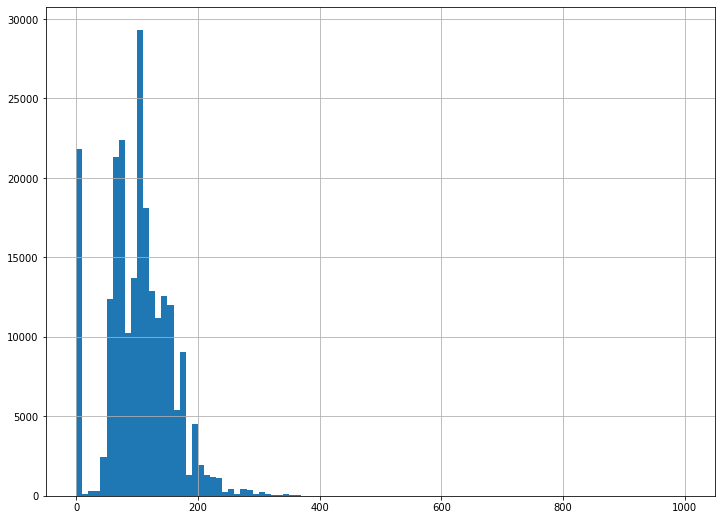

In [28]:
filtr_df = filtr_df.query('Power < 1001')
filtr_df['Power'].hist(bins=100, figsize=(12,9))
filtr_df['Power'].describe()

count    207648.000000
mean        111.495531
std          44.604060
min           1.000000
25%          75.000000
50%         105.000000
75%         140.000000
max         400.000000
Name: Power, dtype: float64

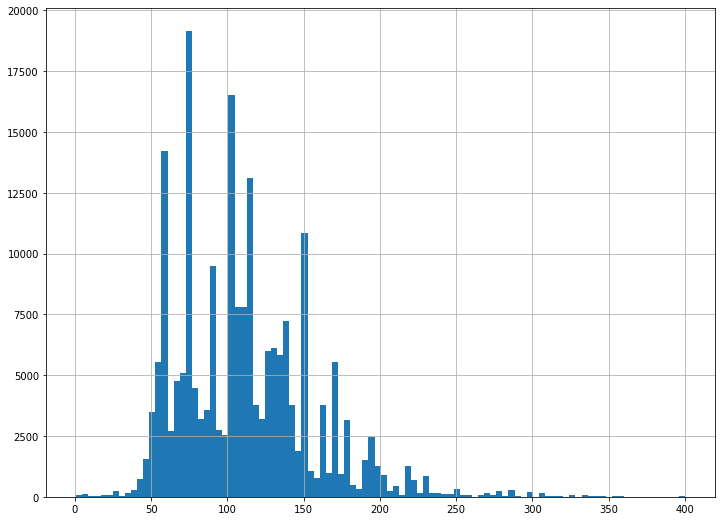

In [29]:
filtr_df = filtr_df.query('0 < Power < 401')
filtr_df['Power'].hist(bins=100, figsize=(12,9))
filtr_df['Power'].describe()

count    207216.000000
mean        111.552520
std          44.138358
min          25.000000
25%          75.000000
50%         105.000000
75%         140.000000
max         350.000000
Name: Power, dtype: float64

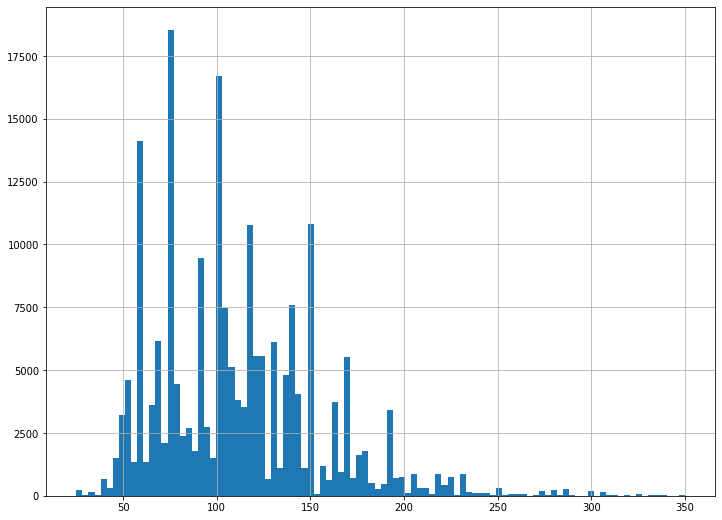

In [30]:
good_df = filtr_df.query('24 < Power < 351')
good_df['Power'].hist(bins=100, figsize=(12,9))
good_df['Power'].describe()

In [31]:
good_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207216 entries, 3 to 354368
Data columns (total 10 columns):
VehicleType         207216 non-null object
Gearbox             207216 non-null object
Power               207216 non-null int64
Kilometer           207216 non-null int64
FuelType            207216 non-null object
Brand               207216 non-null object
NotRepaired         207216 non-null object
RegistrationYear    207216 non-null int64
Model               207216 non-null object
Price               207216 non-null int64
dtypes: int64(4), object(6)
memory usage: 17.4+ MB


Очистили данные от выбросов, теперь они выглядят как рай для перфекциониста. Почти. Надо еще провести замену столбцов Gearbox и NotRepaired на булев тип.  

IsManualGearbox. 1(manual) - означает механическую коробку передач, 0(auto) - автоматическую.  
IsNotRepaired. 1(yes) - означает машину без ремонта, 0(no) - с ремонтом.

In [32]:
good_df['IsManualGearbox'] = 0
good_df.loc[good_df['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
display(good_df['IsManualGearbox'].value_counts())
good_df['Gearbox'].value_counts()

1    173534
0     33682
Name: IsManualGearbox, dtype: int64

manual    173534
auto       33682
Name: Gearbox, dtype: int64

In [33]:
good_df['IsNotRepaired'] = 0
good_df.loc[good_df['NotRepaired'] == 'yes', 'IsNotRepaired'] = 1
display(good_df['IsNotRepaired'].value_counts())
good_df['NotRepaired'].value_counts()

0    157197
1     50019
Name: IsNotRepaired, dtype: int64

no     157197
yes     50019
Name: NotRepaired, dtype: int64

In [34]:
good_df.drop(['NotRepaired','Gearbox'], inplace=True, axis=1)
good_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207216 entries, 3 to 354368
Data columns (total 10 columns):
VehicleType         207216 non-null object
Power               207216 non-null int64
Kilometer           207216 non-null int64
FuelType            207216 non-null object
Brand               207216 non-null object
RegistrationYear    207216 non-null int64
Model               207216 non-null object
Price               207216 non-null int64
IsManualGearbox     207216 non-null int64
IsNotRepaired       207216 non-null int64
dtypes: int64(6), object(4)
memory usage: 17.4+ MB


#### Выводы  

В начале предобработки данных мы выделили признаки, необходимые для обучения модели, которые могут повлиять на цену. 
Это 
VehicleType,
Gearbox, 
Power,
Kilometer, 
FuelType, 
Brand,
NotRepaired, 
RegistrationYear,
Model.

Остальные столбцы мы удалили, так как для модели не требуются, ибо не влияют на стоимость.  

Затем обработали эти признаки, разобрались с пропущеными значениями, дубликатами, выбросами.   

VehicleType - восстановили пропущенные значения по популярному типу из столбца Brand.  
Gearbox - для всех NaN установили значение 'manual'.  
Power - исправили на реальные значения в машинах.  
FuelType - восстановили пропущенные значения по популярному типу из столбца Brand.  
NotRepaired - для всех NaN установили значение 'yes'.  
RegistrationYear - исправили на реальные значения в машинах.  
Model - для всех NaN установили значение 'unknown'.  

Данные готовы для обучения моделей. Го!

## Обучение моделей

Проведем обучение следующих моделей:

LinearRegression  
DecisionTreeRegressor  
LGBMRegressor  

В качестве метрики для всех моделей будем использовать MSE и в финальной таблице переведем в RMSE. 
Качество моделей будем проверять на кроссвалидации.

Для этого нам понадобится три типа признаков для кроссвалидации:

Неизмененные. Название original_features.  
Закодированные методом OHE. Название ohe_features.  
Закодированные методом OE. Название ordinal_features.

In [35]:
original_features = good_df.drop('Price', axis=1)

encoder = OrdinalEncoder()
cat_columns = ['VehicleType','FuelType','Brand','Model']
cat_features = original_features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features), 
                            columns=cat_features.columns, 
                            index=cat_features.index)
ordinal_features = original_features.copy()
for column in cat_columns:
    ordinal_features[column] = cat_features[column]

ohe_features = pd.get_dummies(original_features, drop_first=True)

target = good_df['Price']

In [36]:
original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=19072020)

ordinal_features_train = ordinal_features.loc[original_features_train.index, :]
ordinal_features_test = ordinal_features.loc[original_features_test.index, :]

ohe_features_train = ohe_features.loc[original_features_train.index, :]
ohe_features_test = ohe_features.loc[original_features_test.index, :]

**Начнем с Линейной регрессии**

In [37]:
%%time

regressor = LinearRegression()
cv_RMSE_LR = (cross_val_score(regressor, 
                              ohe_features_train, 
                              target_train, 
                              cv=5, 
                              scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)

Mean RMSE from CV of LinearRegression = 1348.342754438422
CPU times: user 57.6 s, sys: 25 s, total: 1min 22s
Wall time: 1min 22s


In [38]:
%%time

regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
cv_RMSE_LR_S = (cross_val_score(pipeline, 
                                ohe_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR_S)

Mean RMSE from CV of LinearRegression = 2821845554728.0405
CPU times: user 1min 1s, sys: 29.8 s, total: 1min 31s
Wall time: 1min 32s


Масштабирование признаков ухудшает модель. Откажемся от применения масштаба.

**Регрессия DecisionTreeRegressor** 

Проведем два эксперимента.

Проверим модель на признаках, закодированных по методу OHE, затем по методу OE.

In [39]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 'max_depth':max_depth_list, 'random_state':[19072020]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Best parameters:")
print()
print(clf.best_params_)
print()
print("Grid scores:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ohe = (max(means)*-1) ** 0.5

Best parameters:

{'criterion': 'mse', 'max_depth': 14, 'random_state': 19072020}

Grid scores:

1544.276950 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 19072020}
1459.952608 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 19072020}
1366.394920 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 19072020}
1311.269924 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 19072020}
1257.279781 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 19072020}
1210.280290 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 19072020}
1174.484180 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 19072020}
1142.497868 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 19072020}
1120.576999 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 19072020}
1105.059643 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 19072020}
1092.194112 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 19072020}
1084.988061 for {'criterion': '

In [40]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 'max_depth':max_depth_list, 'random_state':[19072020]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters:")
print()
print(clf.best_params_)
print()
print("Grid scores:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ordinal = (max(means)*-1) ** 0.5

Best parameters:

{'criterion': 'mse', 'max_depth': 12, 'random_state': 19072020}

Grid scores:

1544.276950 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 19072020}
1456.183548 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 19072020}
1363.514235 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 19072020}
1308.206372 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 19072020}
1250.692740 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 19072020}
1206.316940 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 19072020}
1165.338949 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 19072020}
1135.413249 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 19072020}
1110.101091 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 19072020}
1093.836362 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 19072020}
1088.683567 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 19072020}
1089.264170 for {'criterion': '

Обучение на OHE данных дало похожий результат, что и порядковое кодирование признаков. Занесем оба эксперимента в финальную таблицу.

**Регрессия LGBMRegressor**

In [41]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 'learning_rate':[0.1, 0.3, 0.5], 'random_state':[19072020]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters:")
print()
print(clf.best_params_)
print()
print("Grid scores:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

Best parameters:

{'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 19072020}

Grid scores:

984.673587 for {'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 19072020}
950.902265 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 19072020}
938.641238 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 19072020}
961.731185 for {'learning_rate': 0.3, 'num_leaves': 31, 'random_state': 19072020}
943.444740 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 19072020}
941.418401 for {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 19072020}
961.792481 for {'learning_rate': 0.5, 'num_leaves': 31, 'random_state': 19072020}
957.395269 for {'learning_rate': 0.5, 'num_leaves': 100, 'random_state': 19072020}
963.516721 for {'learning_rate': 0.5, 'num_leaves': 200, 'random_state': 19072020}

CPU times: user 4min 49s, sys: 2.23 s, total: 4min 51s
Wall time: 4min 55s


#### Выводы 

Были изучены 3 регрессионных модели - LinearRegression, DecisionTreeRegressor, LGBMRegressor.  

В качестве метрики для всех моделей использовалась RMSE.   

Зафиксированы лучшие гиперпараметры и время их выполнения.

## Анализ моделей

Проведем обучение на каждой модели с лучшими гиперпараметрами.

**Линейная регрессия**

In [42]:
%%time

model = LinearRegression()
model.fit(ohe_features_train, target_train)

CPU times: user 12.6 s, sys: 3.72 s, total: 16.4 s
Wall time: 16.4 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
%%time

target_predict = model.predict(ohe_features_test)

CPU times: user 83.6 ms, sys: 124 ms, total: 207 ms
Wall time: 203 ms


In [44]:
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_LR

1350.155093172977

**DecisionTreeRegressor**

In [45]:
%%time

model = DecisionTreeRegressor(criterion='mse', max_depth=15, random_state=19072020) 
model.fit(ohe_features_train, target_train)

CPU times: user 3.88 s, sys: 135 ms, total: 4.01 s
Wall time: 4.03 s


DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=19072020, splitter='best')

In [46]:
%%time

target_predict = model.predict(ohe_features_test)

CPU times: user 63.5 ms, sys: 49.5 ms, total: 113 ms
Wall time: 123 ms


In [47]:
final_RMSE_DTR_ohe = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_DTR_ohe

1053.950410550508

In [48]:
%%time

model = DecisionTreeRegressor(criterion='mse', max_depth=13, random_state=19072020) 
model.fit(ordinal_features_train, target_train)

CPU times: user 394 ms, sys: 2.42 ms, total: 397 ms
Wall time: 415 ms


DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=19072020, splitter='best')

In [49]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 14.2 ms, sys: 140 µs, total: 14.4 ms
Wall time: 12.5 ms


In [50]:
final_RMSE_DTR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_DTR_ordinal

1064.4862333916724

**LGBMRegressor**

In [51]:
%%time

model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=19072020)
model.fit(ordinal_features_train, target_train)

CPU times: user 15.2 s, sys: 132 ms, total: 15.3 s
Wall time: 15.6 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=200, objective=None,
              random_state=19072020, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [52]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 1.09 s, sys: 0 ns, total: 1.09 s
Wall time: 1.1 s


In [53]:
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_LGBMR

932.5241205545585

Наконец, сведем все значения в общую таблицу!

In [55]:
index = ['LinearRegression',
         'DecisionTreeRegressor on OHE features',
         'DecisionTreeRegressor on OE features',
         'LGBMRegressor']
data = {'RMSE на CV, евро':[cv_RMSE_LR,
                            cv_RMSE_DTR_ohe,
                            cv_RMSE_DTR_ordinal,
                            cv_RMSE_LGBMR],
        'Время обучения на CV, сек':[82,
                                     274,
                                     28.3,
                                     295],
        'RMSE модели на тестовой выборке, евро':[final_RMSE_LR,
                                                final_RMSE_DTR_ohe,
                                                final_RMSE_DTR_ordinal,
                                                final_RMSE_LGBMR],
        'Время обучения модели, сек':[16.4,
                                      4.03,
                                      0.415,
                                      15.6],
        'Время предсказания модели, сек':[0.203,
                                          0.123,
                                          0.012,
                                          1.1]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,"RMSE на CV, евро","Время обучения на CV, сек","RMSE модели на тестовой выборке, евро","Время обучения модели, сек","Время предсказания модели, сек"
LinearRegression,1348.342754,82.0,1350.155093,16.400,0.203
DecisionTreeRegressor on OHE features,1080.960206,274.0,1053.950411,4.030,0.123
DecisionTreeRegressor on OE features,1088.683567,28.3,1064.486233,0.415,0.012
LGBMRegressor,938.641238,295.0,932.524121,15.600,1.100


#### Выводы 

Лучшей моделью в целом по трем параметрам (качество, скорость обучения, скорость предсказания) можно выделить DecisionTreeRegressor с подготовленными признаками. Соотношение скорости и тточности на данной модели является лучшим из остальных моделей.   

Если смотреть только на точность, то в лидеры выходит LGBMRegressor, затем DecisionTreeRegressor. 

LinearRegression показала себя на этой задаче очень слабо.  

Иходя из анализа моделей можно сделать следующий вывод:   

Для быстрых решений с хорошей точностью подойдет DecisionTreeRegressor с подготовленными признаками.  
Если в задаче необходима точность и есть время для обучения, то LGBMRegressor поможет предсказать лучше всех. 